![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [6]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


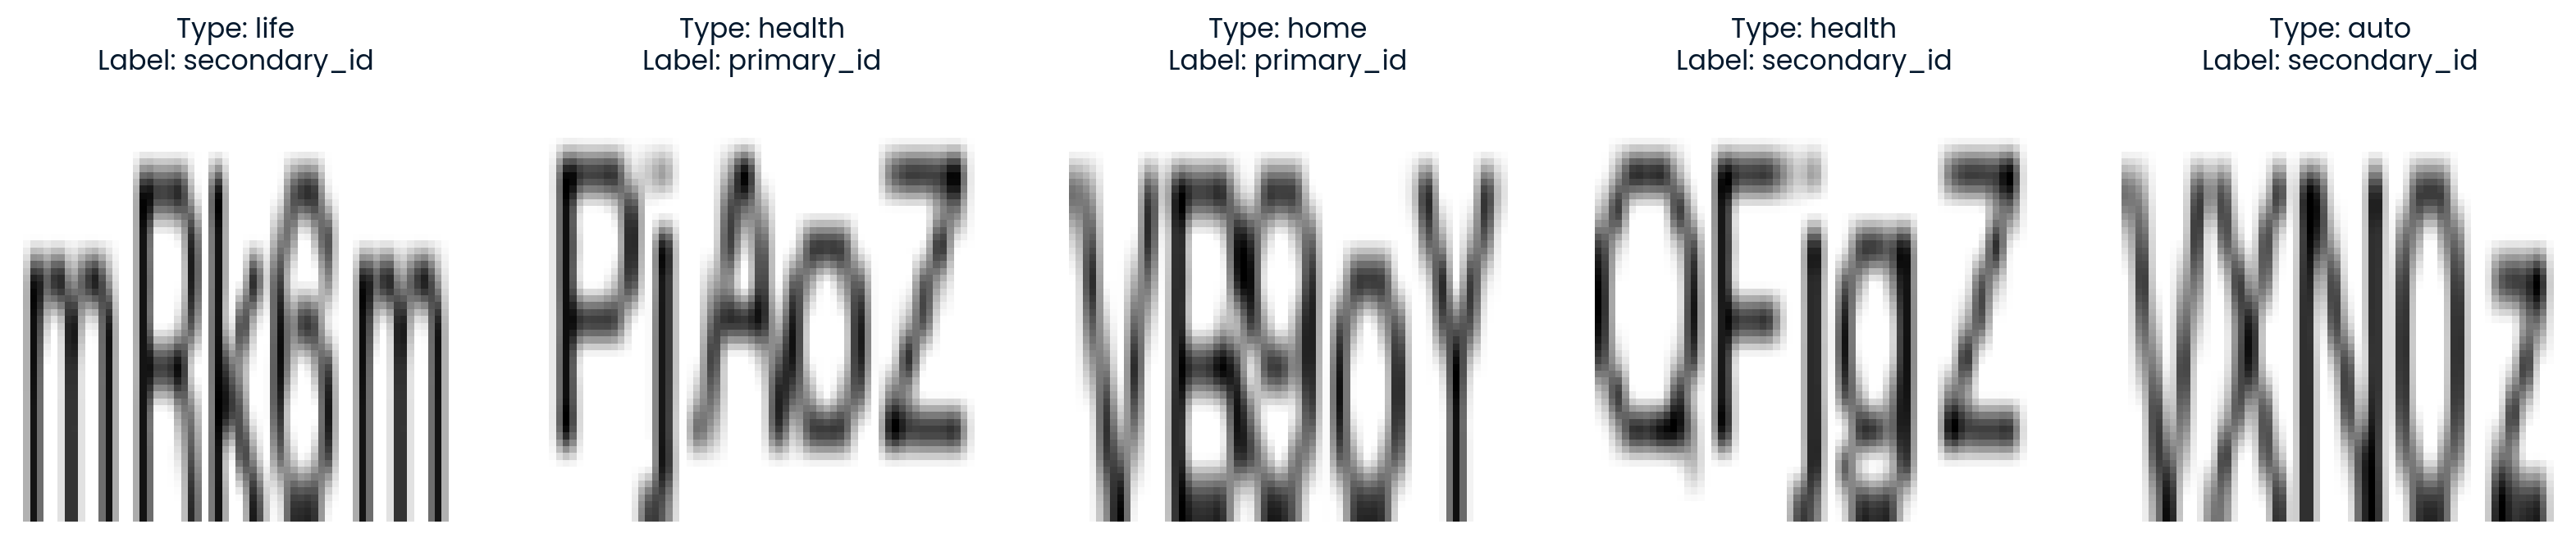

In [7]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [8]:
# Define the model's structure
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)  
        )
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 + 10, 64), 
            nn.ReLU(),
            nn.Linear(64, 2)  
        )
        
    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        x = torch.cat((x_image, x_type), dim=1)  
        return self.classifier(x)


In [9]:
# Load the data in batches
train_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Call the model
model = OCRModel()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [10]:
# Train for ten epochs
for epoch in range(10):  
    for (images, types), labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images, types)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.8299201726913452
Epoch 2, Loss: 0.7229047417640686
Epoch 3, Loss: 1.0965707302093506
Epoch 4, Loss: 0.682033896446228
Epoch 5, Loss: 0.6480615735054016
Epoch 6, Loss: 0.5028743147850037
Epoch 7, Loss: 0.5206127166748047
Epoch 8, Loss: 0.5977117419242859
Epoch 9, Loss: 0.46299973130226135
Epoch 10, Loss: 0.46447378396987915
